# Visualization : RF

###  Setup

* First, set up Python, `numpy`, and `matplotlib`.

In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (5,5)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

# The caffe module needs to be on the Python path;
# We added it to PYTHONPATH (e.g. from ~/.bash_profile)

import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

### Reading the data

We'll read the image/label pairs from our Emotion6 groundtruth, creating two lists of images (one for each label).


### Loading the model & setting up caffe

We will load the model with the best performance, i.e. the one from `e2`.

In [2]:
# todo: save the final models to experiments/Emotion6 folder, create "deploy" models
model_definition = 'Emotion6/e2.deploy.prototxt'
model_weights    = 'Emotion6/e2.caffemodel'
caffe.set_mode_gpu()
net = caffe.Net(model_definition,
         model_weights,
         caffe.TEST)
print 'Net model sucessfully loaded'

Net model sucessfully loaded


In [3]:
# load the mean places image 
mu = np.load('Emotion6/places205CNN_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

mean-subtracted values: [('B', 104.92972906422801), ('G', 113.25471068604384), ('R', 116.20969209889881)]


### Classifying images in the test set

In [4]:
def classify_image(image_file):
    image = caffe.io.load_image(image_file)
    net.blobs['data'].data[...] = transformer.preprocess('data', image)
    # perform classification
    net.forward()
    
def show_image(image_file):
    image = caffe.io.load_image(image_file)
    plt.imshow(image)
    plt.show()

### Visualizing results

we are going to select the best scores for true positives and false positives in the test set

### Visualization of net internals


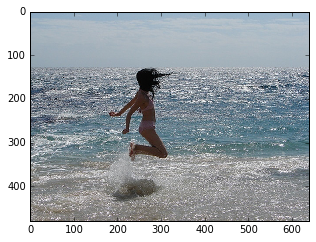

Classification result is 1 with probability 1.000000


In [5]:
# first of all let's choose a particular image
test_image = '../databases/Emotion6/images/joy/13.jpg'
show_image(test_image)
classify_image(test_image)

output_prob = net.blobs['prob'].data[0]
print 'Classification result is %i with probability %f' %(output_prob.argmax(), output_prob.max())

In [6]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    print 'data shape: '
    print data.shape# normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

### Visualizing receptor fields

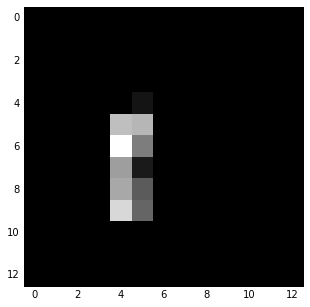

In [13]:
# we select the 77th unit from the conv5 layer, after visualizing the activations in this layer with 
# vis_square(net.blobs['conv5'].data[0,:])

activation = net.blobs['conv5'].data[0,77]
plt.imshow(activation)



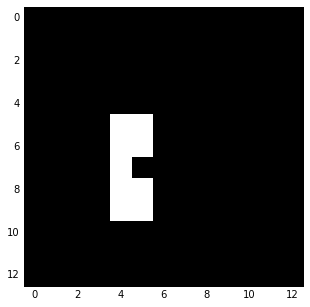

In [8]:
indices = activation > 0.3*activation.max()
activation = np.zeros(activation.shape)
activation[indices] = 1
plt.imshow(activation)

In [9]:
image = caffe.io.load_image(test_image)
def inner_image(img):
    minsize = np.min(img.shape[:2])
    x0 = (img.shape[0]-minsize)/2
    y0 = (img.shape[1]-minsize)/2
    return img[x0:x0+minsize, y0:y0+minsize,:]

image = inner_image(image)

In [10]:
def generate_circle_mask(array, a, b, r):
    n = array.shape[0]
    y,x = np.ogrid[-a:n-a, -b:n-b]
    mask = x*x + y*y <= r*r
    array[mask] = 1
    return array

ii, jj = activation.nonzero()
mask = np.zeros(image.shape[:2])
sx = 480 / activation.shape[0]
sy = 480 / activation.shape[1]
for i, j in zip(ii,jj):
    mask = generate_circle_mask(mask,sx*i,sy*j,65) # accumulative    

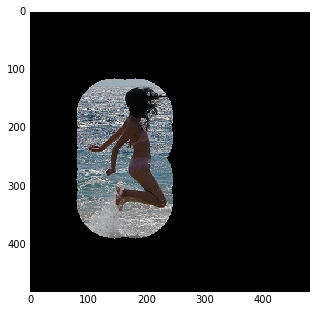

In [11]:
masked = inner_image(image) * mask[:,:,None]
masked = masked / masked.max()

plt.imshow(masked)